In [ ]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow import keras
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/266/booksummaries.txt'

df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8', header=None)

# Define the column names
df.columns = ['ID', 'MID', 'Title', 'Author', 'Date', 'Genres', 'Summary']

# Function to parse JSON safely
def parse_json_safe(json_str):
    try:
        if isinstance(json_str, str):  # Check if the value is a string
            return json.loads(json_str)
        else:
            return {}  # Return an empty dict if not a string
    except json.JSONDecodeError:
        return {}  # Return an empty dict if JSON decoding fails

# Apply the function to the 'Genres' column
df['Genres'] = df['Genres'].apply(parse_json_safe)

# Function to extract genres from the parsed JSON
def extract_genres(genre_dict):
    if isinstance(genre_dict, dict):
        return list(genre_dict.values())
    return []

# Apply the function to the 'Genres' column to get lists of genres
df['genre_list'] = df['Genres'].apply(extract_genres)

df = df.drop(columns = ['Genres', 'MID'])

df.head(4)


,ID,Title,Author,Date,Summary,genre_list
0,620,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p...","[Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]"
1,843,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and...","[Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]"
2,986,The Plague,Albert Camus,1947,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t...","[Existentialism, Fiction, Absurdist fiction, Novel]"
3,1756,An Enquiry Concerning Human Understanding,David Hume,NaN,"The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introdu...",[]


In [ ]:
# Exploratory Analysis
len(df.index)

16559

In [ ]:
# Unique genres
flattened_genres = [genre for sublist in df['genre_list'] for genre in sublist]

genre_counts = {genre: flattened_genres.count(genre) for genre in set(flattened_genres)}

# Convert to a DataFrame
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])

# Sort the DataFrame by count
sorted_genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Print the sorted DataFrame
print(sorted_genre_counts_df)

                    Genre  Count
0                 Fiction   4747
1     Speculative fiction   4314
2         Science Fiction   2870
3                   Novel   2463
4                 Fantasy   2413
..                    ...    ...
222  Boys' school stories      1
223        Alien invasion      1
224         Space western      1
225     Police procedural      1
226             Marketing      1

[227 rows x 2 columns]


In [ ]:
sorted_genre_counts_df

,Genre,Count
0,Fiction,4747
1,Speculative fiction,4314
2,Science Fiction,2870
3,Novel,2463
4,Fantasy,2413
...,...,...
222,Boys' school stories,1
223,Alien invasion,1
224,Space western,1
225,Police procedural,1


In [ ]:
# remove samples with 0 genre tags
df = df[~(df['genre_list'].str.len() == 0)]
df = df[~(df['Summary'].str.len() == 0)]

In [ ]:
len(df.index)

12841

In [ ]:
# Book w/ most labels
num_genres = pd.Series([len(sublist) for sublist in df['genre_list']])

num_genres_counts = num_genres.value_counts()
num_genres_counts

,count
1,4555
2,3532
3,2275
4,1428
5,653
6,258
7,101
8,26
9,11
11,1


In [ ]:
num_genres.median()
num_genres.mean()

2.3365781481193055

### Sample 5,000 Records so we predict 1,000.

In [ ]:
random_seed = 42

# Sample 5000 records with the random seed
df = df.sample(5000, random_state=random_seed)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

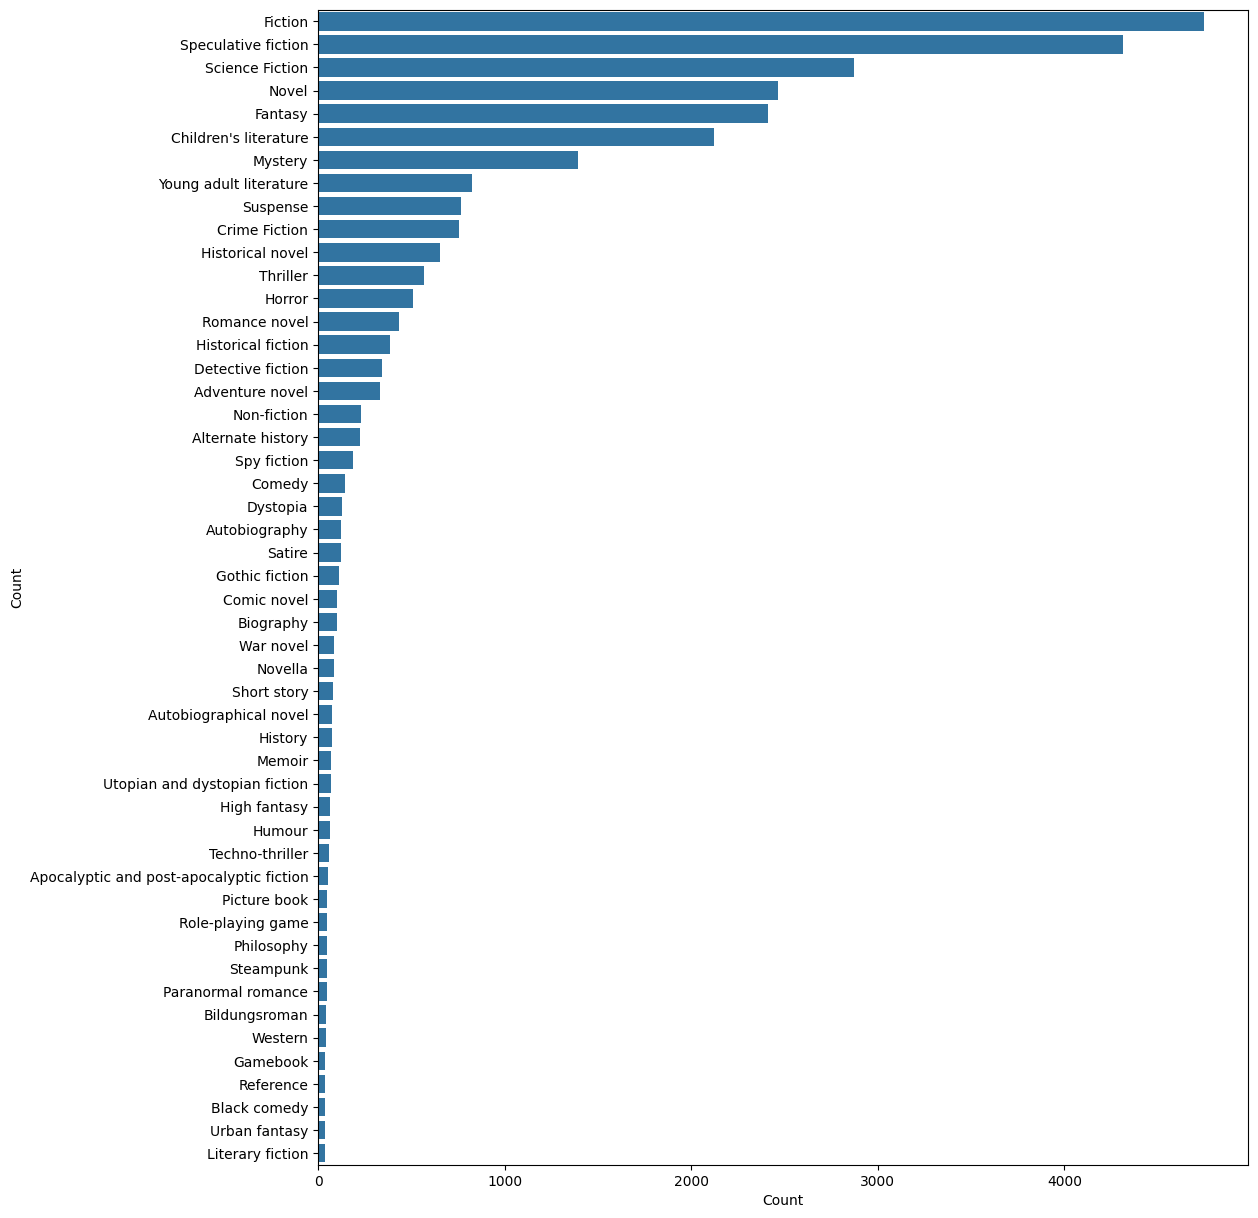

In [ ]:
g = sorted_genre_counts_df.nlargest(columns="Count", n = 50)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Genre")
ax.set(ylabel = 'Count')
plt.show()

#### 227 distinct genres, With a long tail.

## Bag of Words Baseline

In [ ]:
import nltk
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [ ]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()

    return text

In [ ]:
df['clean_summary'] = df['Summary'].apply(lambda x: clean_text(x))

In [ ]:
df[['Summary', 'clean_summary']].sample(3)

,Summary,clean_summary
1305,"The plot follows Harvard symbologist Robert Langdon, as he tries to stop the Illuminati, a legendary secret society, from destroying Vatican City with the newly discovered power of antimatter. CERN director Maximilian Kohler discovers one of the facility's physicists, Leonardo Vetra, murdered. ...",the plot follows harvard symbologist robert langdon as he tries to stop the illuminati a legendary secret society from destroying vatican city with the newly discovered power of antimatter cern director maximilian kohler discovers one of the facilitys physicists leonardo vetra murdered his chest...
8402,"A wealthy young English gentleman, Louis Trevelyan, visits the fictional Mandarin Islands, a distant British possession, and becomes smitten with Emily Rowley, the eldest daughter of the governor, Sir Marmaduke Rowley. The Rowleys accompany Trevelyan to London, where he marries Emily. When the ...",a wealthy young english gentleman louis trevelyan visits the fictional mandarin islands a distant british possession and becomes smitten with emily rowley the eldest daughter of the governor sir marmaduke rowley the rowleys accompany trevelyan to london where he marries emily when the rest of th...
5356,"Moomintroll, Sniff and Snufkin discover the Hobgoblin's Hat on a mountain-top, unaware of its strange powers. An egg shell discarded into the hat becomes five clouds the children ride and play with. Next day the clouds have disappeared and nobody knows where they came from. Moomintroll hides in...",moomintroll sniff and snufkin discover the hobgoblins hat on a mountain top unaware of its strange powers an egg shell discarded into the hat becomes five clouds the children ride and play with next day the clouds have disappeared and nobody knows where they came from moomintroll hides inside th...


In [ ]:
# remove samples with 0 genre tags
df = df[~(df['genre_list'].str.len() == 0)]

## **1.0 Simple Bag-of-Words Baseline**

### Converting Text to Features

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genre_list'])

# transform target variable
y = multilabel_binarizer.transform(df['genre_list'])

In [ ]:
# split dataset into training and validation set
xtrain, xtest, ytrain, ytest = train_test_split(df['clean_summary'], y, test_size=0.2, random_state=9)

In [ ]:
# create TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(xtrain)  # Corrected instance method call
X_test_tfidf = vectorizer.transform(xtest)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_tfidf, ytrain)

RandomForestClassifier()

In [ ]:
# fit model on train data, using training X and Y (Plot summaries and genre vectors)
clf.fit(X_train_tfidf, ytrain)

RandomForestClassifier()

In [ ]:
# make predictions for validation set
y_pred = clf.predict(X_test_tfidf)

In [ ]:
# evaluate performance

# Calculate accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = precision_score(ytest, y_pred, average='micro')
print(f'Precision: {precision}')

# Calculate recall
recall = recall_score(ytest, y_pred, average='micro')
print(f'Recall: {recall}')

# f1 score
F1_score = f1_score(ytest, y_pred, average="micro")
print(f'F1 Score: {F1_score}')

Accuracy: 0.016
Precision: 0.7916666666666666
Recall: 0.04896907216494845
F1 Score: 0.09223300970873786


In [ ]:
y_pred.shape

(1000, 193)

In [ ]:
'''

### THIS CODE WAS THROWING ERRORS, I WANTED TO APPLY A THRESHOLD TO THE RANDOM FOREST PREDICTIONS...


t = 0.2

# Predict probabilities for multi-label classification
y_pred_prob = np.array([clf.predict_proba(X_test_tfidf) for clf in clf.estimators_]).mean(axis=0)

# Initialize an array to store binary predictions
y_pred_new = np.zeros_like(y_pred_prob, dtype=int)

# Apply threshold to convert probabilities to binary predictions
for i in range(y_pred_prob.shape[0]):
    for j in range(y_pred_prob.shape[1]):
        y_pred_new[i][j] = 1 if y_pred_prob[i][j] >= threshold else 0

'''

'\n\n### THIS CODE WAS THROWING ERRORS, I WANTED TO APPLY A THRESHOLD TO THE RANDOM FOREST PREDICTIONS...\n\n\nt = 0.2\n\n# Predict probabilities for multi-label classification\ny_pred_prob = np.array([clf.predict_proba(X_test_tfidf) for clf in clf.estimators_]).mean(axis=0)\n\n# Initialize an array to store binary predictions\ny_pred_new = np.zeros_like(y_pred_prob, dtype=int)\n\n# Apply threshold to convert probabilities to binary predictions\nfor i in range(y_pred_prob.shape[0]):\n    for j in range(y_pred_prob.shape[1]):\n        y_pred_new[i][j] = 1 if y_pred_prob[i][j] >= threshold else 0\n\n'

In [ ]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
multilabel_binarizer.inverse_transform(y_pred)[100]

()

In [ ]:
decoded_labels = multilabel_binarizer.inverse_transform(y_pred)

# Count the number of records with empty tuples
count_empty = sum(len(labels) == 0 for labels in decoded_labels)
print(count_empty)

889


## Including Threshold

Noticed that Many Predictions have 0 genres. Updating the threshold value to be 0.3 dramatically improved the F1 score and the practical outputs (now predictions have genres).

### Cosine Similarities

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
# Function to get embeddings for a list of genres
def get_genre_embedding(genre):
    inputs = tokenizer(genre, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

all_genres = list(set(flattened_genres))

# Get embeddings for all unique genres
# genre_embeddings = get_genre_embeddings(all_genres)

def get_genres_embeddings(genres_list):
    return [get_genre_embedding(genre) for genre in genres_list]


# The inverse_transform genre lists are actually 1-D arrays of tuples. We need to convert to 2-D list of lists.
def listpadding(list_o_tuples):
    # Determine the maximum tuple length
    max_len = max(len(t) for t in list_o_tuples)

    # Pad the tuples to have the same length
    padded_genres = [t + ('',) * (max_len - len(t)) for t in list_o_tuples]

    # Convert to a 2-D numpy array
    return np.array(padded_genres)


#### Cosine Similarities w/ Actual Examples

In [ ]:
# Compute cosine similarities for each pair of actual and predicted genres
def calculate_cosine_similarities(y_actual, y_pred):
    similarities = []
    for actual_genres, pred_genres in zip(y_actual, y_pred):
        actual_embeddings = get_genres_embeddings(actual_genres)
        pred_embeddings = get_genres_embeddings(pred_genres)

        # Calculate pairwise cosine similarity
        if actual_embeddings and pred_embeddings:
            similarity_matrix = cosine_similarity(actual_embeddings, pred_embeddings)
            avg_similarity = np.mean(similarity_matrix)
        else:
            avg_similarity = 0.0
        similarities.append(avg_similarity)
    return similarities

# Calculate cosine similarities between the text vectors of actual and predicted genres
ytest_list = listpadding(multilabel_binarizer.inverse_transform(ytest))
ypred_list = listpadding(multilabel_binarizer.inverse_transform(y_pred))


cosine_similarities = calculate_cosine_similarities(multilabel_binarizer.inverse_transform(ytest)[0:51],
                                                  multilabel_binarizer.inverse_transform(y_pred)[0:51])

# Print the cosine similarities
for idx, similarity in enumerate(cosine_similarities):
    print(f"Document {idx + 1}: Cosine Similarity = {similarity:.4f}")

Document 1: Cosine Similarity = 0.0000
Document 2: Cosine Similarity = 0.0000
Document 3: Cosine Similarity = 0.0000
Document 4: Cosine Similarity = 0.0000
Document 5: Cosine Similarity = 0.0000
Document 6: Cosine Similarity = 0.0000
Document 7: Cosine Similarity = 0.0000
Document 8: Cosine Similarity = 0.8601
Document 9: Cosine Similarity = 0.0000
Document 10: Cosine Similarity = 0.0000
Document 11: Cosine Similarity = 0.7793
Document 12: Cosine Similarity = 0.0000
Document 13: Cosine Similarity = 0.0000
Document 14: Cosine Similarity = 0.0000
Document 15: Cosine Similarity = 0.0000
Document 16: Cosine Similarity = 0.0000
Document 17: Cosine Similarity = 0.0000
Document 18: Cosine Similarity = 0.0000
Document 19: Cosine Similarity = 0.0000
Document 20: Cosine Similarity = 0.0000
Document 21: Cosine Similarity = 0.0000
Document 22: Cosine Similarity = 0.0000
Document 23: Cosine Similarity = 0.0000
Document 24: Cosine Similarity = 0.0000
Document 25: Cosine Similarity = 0.0000
Document 

#### Average Cosine Similarities as an Output Metric

In [ ]:
def calculate_cosine_similarities(y_actual, y_pred):
    all_similarities = []
    for actual_genres, pred_genres in zip(y_actual, y_pred):
        actual_embeddings = get_genres_embeddings(actual_genres)
        pred_embeddings = get_genres_embeddings(pred_genres)

        # Calculate pairwise cosine similarity
        if actual_embeddings and pred_embeddings:
            similarity_matrix = cosine_similarity(actual_embeddings, pred_embeddings)
            avg_similarity = np.mean(similarity_matrix)
        else:
            avg_similarity = 0.0
        all_similarities.append(avg_similarity)

    # Calculate and return the overall average similarity
    overall_avg_similarity = np.mean(all_similarities)
    return overall_avg_similarity

# Calculate overall cosine similarity
overall_cosine_similarity = calculate_cosine_similarities(multilabel_binarizer.inverse_transform(ytest)[0:1000],
                                                  multilabel_binarizer.inverse_transform(y_pred)[0:1000])

# Print the overall cosine similarity
print(f"Overall Cosine Similarity = {overall_cosine_similarity:.4f}")

Overall Cosine Similarity = 0.0969


Although it's more computationaly intensive, we'll use the pairwise cosine similarities. This measure captured perfect matches ("fiction" and "fiction"), while the null-padded cosine similarities didn't score these the highest.

In [ ]:
print(multilabel_binarizer.inverse_transform(y_pred)[430])
print(multilabel_binarizer.inverse_transform(ytest)[430])
calculate_cosine_similarities(multilabel_binarizer.inverse_transform(ytest)[430],
                                                  multilabel_binarizer.inverse_transform(y_pred)[430])

()
("Children's literature", 'Historical fiction', 'Historical novel')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
print(multilabel_binarizer.inverse_transform(y_pred)[48])
print(multilabel_binarizer.inverse_transform(ytest)[48])

()
('Novel',)


In [ ]:
print(multilabel_binarizer.inverse_transform(y_pred)[50])
print(multilabel_binarizer.inverse_transform(ytest)[50])

()
('Biography', 'Drama', 'Historical romance')
